In [2]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [3]:
pd.set_option("display.precision", 8)

In [4]:
data_root='./op'

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

print(TRAINING_DATA_DIR);

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)

./op
Found 715 images belonging to 2 classes.
Found 178 images belonging to 2 classes.


In [6]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([k.title() for k, v in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Document' 'Garbage']


In [7]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='binary_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
23/23 [==============================] - 59s 2s/step - loss: 0.6251 - acc: 0.7269 - val_loss: 0.2128 - val_acc: 0.9382
Epoch 2/10
23/23 [==============================] - 41s 2s/step - loss: 0.2798 - acc: 0.9065 - val_loss: 0.1410 - val_acc: 0.9607
Epoch 3/10
23/23 [==============================] - 41s 2s/step - loss: 0.2433 - acc: 0.9128 - val_loss: 0.1288 - val_acc: 0.9663
Epoch 4/10
23/23 [==============================] - 42s 2s/step - loss: 0.2707 - acc: 0.8977 - val_loss: 0.1232 - val_acc: 0.9551
Epoch 5/10
23/23 [==============================] - 43s 2s/step - loss: 0.2179 - acc: 0.9327 - val_loss: 0.1223 - val_acc: 0.9551
Epoch 6/10
23/23 [==============================] - 43s 2s/step - loss: 0.2114 - acc: 0.9252 - val_loss: 0.1198 - val_acc: 0.9663
Epoch 7/10
23/23 [==============================] - 42s 2s/step - loss: 0.2002 - acc: 0.9341 - val_loss: 0.1207 - val_acc: 0.9663
Epoch 8/10
23/23 [==============================] - 41s 2s/step - loss: 0.2056 - acc: 0.93

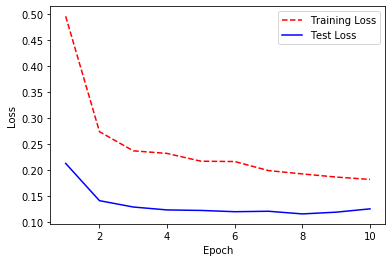

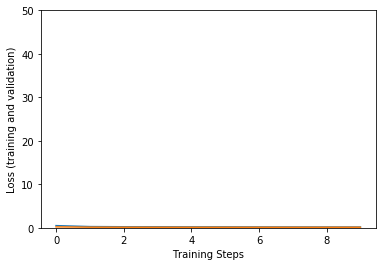

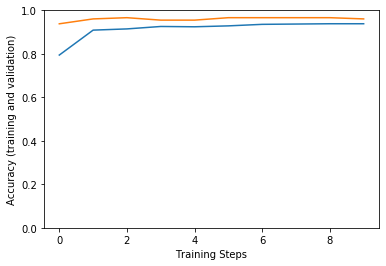

In [9]:
epoch_count = range(1, len(hist["loss"]) + 1)

# Visualize loss history
plt.plot(epoch_count, hist["loss"], 'r--')
plt.plot(epoch_count, hist["val_loss"], 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])


In [11]:
MODEL_PATH = "model"
tf.saved_model.save(model, MODEL_PATH)
assg_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'KerasLayer':hub.KerasLayer})

INFO:tensorflow:Assets written to: model\assets
INFO:tensorflow:Assets written to: model\assets


In [12]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [13]:
tf_model_predictions = assg_model.predict(val_image_batch)

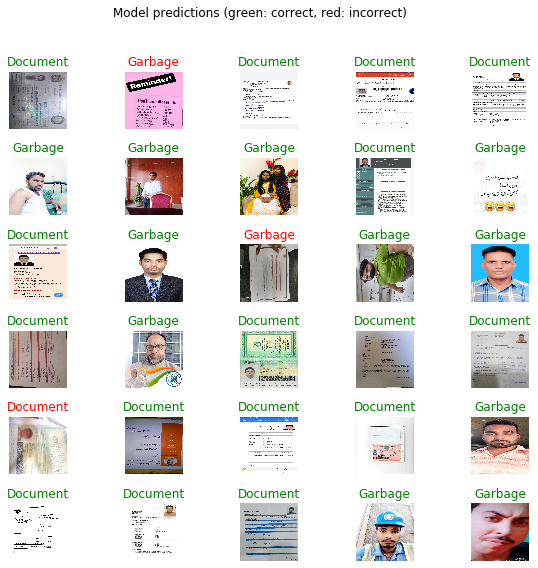

In [15]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")